In [2]:
import json
import os
import re
import spacy
from spacy.tokens import DocBin

# List of exclusion terms
exclusions = [
    "halve", "halved", "lengthwise", "rough", "roughly", "chop", "chopped", "fresh", "freshly", 
    "crack", "cracked", "divide", "divided", "mince", "minced", "rinse", "rinsed", "dry", "dried", 
    "clean", "cleaned", "cut", "cutting", "slice", "sliced", "quarter", "quartered", "pack", 
    "packed", "beat", "beaten", "spray", "sprayed", "coarse", "coarsely", "medium", "fine", 
    "small", "large", "whole", "cup", "cups", "teaspoon", "teaspoons", "tablespoon", "tablespoons", 
    "pound", "pounds", "ounce", "ounces", "gram", "grams", "liter", "liters", "milliliter", 
    "milliliters", "clove", "cloves", "stick", "sticks", "package", "packages", "can", "cans", 
    "bottle", "bottles", "slice", "slices", "bulb", "bulbs", "finely", "medium-sized", "large-sized", 
    "small-sized", "extra-large", "extra-small", "half", "quarter", "third", "fourth", "fifth", 
    "sixth", "seventh", "eighth", "ninth", "tenth", "1", "2", "3", "4", "5", "6", "7", "8", "9", 
    "10", "¼", "½", "¾", "⅛", "⅓", "⅔", "⅕", "⅖", "⅗", "⅘", "⅙", "⅚", "⅐", "⅛", "⅜", "⅝", 
    "⅞", "⅑", "⅒", "à", "á", "â", "ã", "ä", "å", "æ", "a", "dice", "diced", "crush", "crushed", "regular", "bundles", "bundle"
]

# Function to add exclusion terms as non-entities in the training data
def add_exclusion_non_entities(data, exclusions):
    exclusion_pattern = re.compile(r'\b(' + '|'.join(re.escape(term) for term in exclusions) + r')\b', re.IGNORECASE)
    for entry in data:
        entry_text = entry['text']
        for match in re.finditer(exclusion_pattern, entry_text):
            start, end = match.span()
            if not any(start < e and end > s for s, e, _ in entry['label']):
                entry['label'].append((start, end, 'NON-ENTITY'))
    return data

# Load your training data
def load_training_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

# Save corrected training data
def save_training_data(data, output_file_path):
    with open(output_file_path, 'w', encoding='utf-8') as f:
        for entry in data:
            f.write(json.dumps(entry, ensure_ascii=False) + "\n")

# Function to align entity spans with token boundaries
def align_entity_spans(data, nlp):
    aligned_data = []
    for entry in data:
        doc = nlp(entry['text'])
        new_labels = []
        for start, end, label in entry['label']:
            span = doc.char_span(start, end, label=label)
            if span:
                new_labels.append((span.start_char, span.end_char, label))
        entry['label'] = new_labels
        aligned_data.append(entry)
    return aligned_data

# Main script to process data
folder_path = '../Doccano_Labeled_Data/Training_Data'  # Update this path to your folder
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jsonl')]

combined_data = []

print("Files being loaded:")
for file_path in file_paths:
    print(file_path)

# Combine data from all JSONL files
for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line)
            entry.pop('id', None)
            entry.pop('Comments', None)
            combined_data.append(entry)

# Define the test example using the exclusion terms
fake_example_text = (
    "halve halved lengthwise rough roughly chop chopped fresh freshly "
    "crack cracked divide divided mince minced rinse rinsed dry dried "
    "clean cleaned cut cutting slice sliced quarter quartered pack "
    "packed beat beaten spray sprayed coarse coarsely medium fine "
    "small large whole cup cups teaspoon teaspoons tablespoon tablespoons "
    "pound pounds ounce ounces gram grams liter liters milliliter "
    "milliliters clove cloves stick sticks package packages can cans "
    "bottle bottles slice slices bulb bulbs finely medium-sized large-sized "
    "small-sized extra-large extra-small half quarter third fourth fifth "
    "sixth seventh eighth ninth tenth dice diced crush crushed regular bundles bundle"
)

# Define the labels for the fake example
fake_example_labels = [
    (match.start(), match.end(), "NON-ENTITY") for match in re.finditer(r'\b\w+\b', fake_example_text)
]

# Create the fake example dictionary
fake_example = {
    "text": fake_example_text,
    "label": fake_example_labels
}

# Append the fake example to the combined data
combined_data.append(fake_example)

output_file_path = '../NER_Training_Data/combined_training_data.jsonl'
with open(output_file_path, 'w', encoding='utf-8') as f:
    for entry in combined_data:
        f.write(json.dumps(entry, ensure_ascii=False) + "\n")

print(f"Combined data saved to {output_file_path}")

# Load combined training data
training_data = load_training_data(output_file_path)

# Add exclusion terms as non-entities
training_data = add_exclusion_non_entities(training_data, exclusions)

# Align entity spans
nlp = spacy.blank("en")
aligned_data = align_entity_spans(training_data, nlp)

# Save aligned data
aligned_output_file_path = '../NER_Training_Data/aligned_training_data.jsonl'
save_training_data(aligned_data, aligned_output_file_path)

print(f"Aligned data saved to {aligned_output_file_path}")

# Function to prepare training data
def prepare_training_data(data):
    db = DocBin()  # Create a DocBin object to store training examples
    for entry in data:
        doc = nlp.make_doc(entry['text'])  # Create a doc object from the text
        ents = []
        for start, end, label in entry['label']:
            span = doc.char_span(start, end, label=label)
            if span is None:
                raise ValueError(f"Failed to create entity with start: {start}, end: {end}, label: {label}. This entity could not be aligned with token boundaries.")
            ents.append(span)
        doc.ents = ents  # Assign the entities to the doc
        db.add(doc)
    return db

# Prepare the training data
db = prepare_training_data(aligned_data)
db.to_disk("../NER_Training_Data/training_data.spacy")  # Save the training data to a file

print(f"Training data saved to ../NER_Training_Data/training_data.spacy")

Files being loaded:
../Doccano_Labeled_Data/Training_Data\Test_1.jsonl
../Doccano_Labeled_Data/Training_Data\Test_10 - Copy.jsonl
../Doccano_Labeled_Data/Training_Data\Test_10.jsonl
../Doccano_Labeled_Data/Training_Data\Test_11 - Copy.jsonl
../Doccano_Labeled_Data/Training_Data\Test_11.jsonl
../Doccano_Labeled_Data/Training_Data\Test_12_NonLabeled.jsonl
../Doccano_Labeled_Data/Training_Data\Test_2.jsonl
../Doccano_Labeled_Data/Training_Data\Test_3.jsonl
../Doccano_Labeled_Data/Training_Data\Test_4.jsonl
../Doccano_Labeled_Data/Training_Data\Test_5.jsonl
../Doccano_Labeled_Data/Training_Data\Test_6.jsonl
../Doccano_Labeled_Data/Training_Data\Test_7 - Copy.jsonl
../Doccano_Labeled_Data/Training_Data\Test_7.jsonl
../Doccano_Labeled_Data/Training_Data\Test_8.jsonl
../Doccano_Labeled_Data/Training_Data\Test_9 - Copy.jsonl
../Doccano_Labeled_Data/Training_Data\Test_9.jsonl
Combined data saved to ../NER_Training_Data/combined_training_data.jsonl
Aligned data saved to ../NER_Training_Data/alig

In [5]:
import spacy
from spacy.tokens import DocBin

# Script to verify the content of training_data.spacy
def verify_training_data(file_path, num_records=30):
    nlp = spacy.blank("en")
    doc_bin = DocBin().from_disk(file_path)
    docs = list(doc_bin.get_docs(nlp.vocab))
    
    # Get the last num_records documents
    for i, doc in enumerate(docs[-num_records:]):
        print(f"Document {len(docs) - num_records + i + 1}: {doc.text}")
        if doc.ents:
            for ent in doc.ents:
                print(f"  Entity: {ent.text}, Label: {ent.label_}")
        else:
            print("  No entities found.")
        print("\n")

# Verify the content of training_data.spacy
verify_training_data("../NER_Training_Data/training_data.spacy")


Document 332: 5 pounds coarse ground beef, 3/4 cup chili powder , 1/4 cup cayenne pepper , 1/4 cup ground cumin, 1/4 cup salt , 1/4 cup sugar , 32 ounces tomato paste , 10 cloves garlic, minced , 2 12-ounce cans tomato sauce , 1 128-ounce can pinto beans in chili sauce , 1 10-ounce can beef broth , 1 large yellow onion, diced , 1 large green bell pepper, diced , Tamales, for serving
  Entity: 5, Label: NON-ENTITY
  Entity: pounds, Label: NON-ENTITY
  Entity: coarse, Label: NON-ENTITY
  Entity: ground beef, Label: Ingredient
  Entity: cup, Label: NON-ENTITY
  Entity: chili powder, Label: Ingredient
  Entity: cup, Label: NON-ENTITY
  Entity: cayenne pepper, Label: Ingredient
  Entity: cup, Label: NON-ENTITY
  Entity: ground cumin,, Label: Ingredient
  Entity: cup, Label: NON-ENTITY
  Entity: salt, Label: Ingredient
  Entity: cup, Label: NON-ENTITY
  Entity: sugar, Label: Ingredient
  Entity: ounces, Label: NON-ENTITY
  Entity: tomato paste, Label: Ingredient
  Entity: 10, Label: NON-ENTI

Epoch 1, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 8595.197838547498}
Epoch 2, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 2653.9307819453925}
Epoch 3, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 1978.0145015026258}
Epoch 4, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 1590.800548881917}
Epoch 5, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 1426.7068668714962}
Epoch 6, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 1283.381903983524}
Epoch 7, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 1152.3838808200248}
Epoch 8, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 1107.9086569620988}
Epoch 9, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 1031.3297475520185}
Epoch 10, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 987.4763780117565}
Epoch 11, Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 953.2978520906527}
Ep

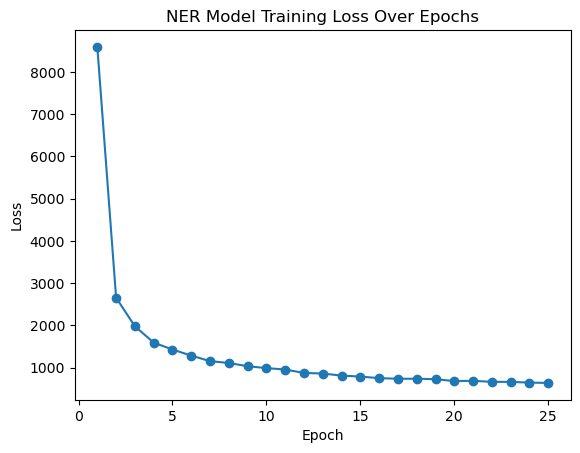

In [6]:
import spacy
from spacy.training.example import Example
from spacy.tokens import DocBin
import random
import json
import pandas as pd
import matplotlib.pyplot as plt

# Function to train the NER model
def train_ner_model():
    # Load a pre-trained model
    nlp = spacy.load("en_core_web_sm")
    ner = nlp.get_pipe("ner")

    # Load the training data
    db = DocBin().from_disk("../NER_Training_Data/training_data.spacy")
    training_data = list(db.get_docs(nlp.vocab))

    # Add custom labels to the NER component
    for doc in training_data:
        for ent in doc.ents:
            ner.add_label(ent.label_)

    # Convert training data to Example objects
    examples = [Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in training_data]

    optimizer = nlp.resume_training()
    loss_values = []    

    # Training loop
    for epoch in range(25):  # Number of training epochs
        random.shuffle(examples)
        losses = {}
        for batch in spacy.util.minibatch(examples, size=2):
            nlp.update(batch, drop=0.35, losses=losses)
        loss_values.append(losses.get("ner", 0.0))
        print(f"Epoch {epoch + 1}, Losses: {losses}")

    plt.plot(range(1, 26), loss_values, marker='o')
    plt.title("NER Model Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    return nlp

# Train the NER model
nlp = train_ner_model()
nlp.to_disk("ner_model_test_class")  # Save the trained model


In [8]:
test_file_path = '../Cleaned_Raw_Data/MASTERDATA1.csv'  # Update this path if necessary
test_df = pd.read_csv(test_file_path)

# Random state number
random_state_number = 2

# Select a random sample of 20 entries
sample_df = test_df.sample(n=20, random_state=random_state_number)

# Extract the ingredients column for testing
test_ingredients = sample_df['ingredients'].tolist()
sample_df.head()

,name,url,ingredients
8590,Citrus and SpiceBrined Baby Back Ribs,https://www.foodnetwork.com/recipes/food-netwo...,"1 orange , Kosher salt , 34 cup packed light b..."
22457,Moscow Mule Cocktail,https://www.foodnetwork.com/recipes/giada-de-l...,"1 12 cups MintFlavored Vodka, recipe follows ,..."
12475,Fennel Soup Gratin,https://www.foodnetwork.com/recipes/ina-garten...,", 14 pound unsalted butter, 8 cups thinly slic..."
12353,Famous Roast Garlic Crab,https://www.foodnetwork.com/recipes/michael-ch...,", 6 Dungeness crabs, about 1 14 pounds each, c..."
5525,Carrot and Squash Curry Soup,https://www.foodnetwork.com/recipes/ree-drummo...,"3 tablespoons olive oil , 5 cloves garlic, min..."


In [9]:
# Function to display the results
def display_results(test_ingredients, nlp):
    results = []
    for ingredients in test_ingredients:
        doc = nlp(ingredients)
        extracted_ents = [ent.text for ent in doc.ents]  # Directly extract entity texts
        results.append((ingredients, ', '.join(extracted_ents)))
    
    results_df = pd.DataFrame(results, columns=['Original Ingredients', 'Extracted Entities'])
    return results_df

# Load the pre-trained NER model
nlp = spacy.load("ner_model_test_class")  # Update with your model path if different

# Display the results
results_df = display_results(test_ingredients, nlp)

# Print the DataFrame
print(results_df)

# Optionally, save the DataFrame to a CSV file

                                 Original Ingredients  \
0   1 orange , Kosher salt , 34 cup packed light b...   
1   1 12 cups MintFlavored Vodka, recipe follows ,...   
2   , 14 pound unsalted butter, 8 cups thinly slic...   
3   , 6 Dungeness crabs, about 1 14 pounds each, c...   
4   3 tablespoons olive oil , 5 cloves garlic, min...   
5   2 tablespoons vegetable oil , 1 2pound boneles...   
6   , 2 cups gin, 2 tablespoons loose leaf earl gr...   
7   8 skinon, bonein chicken thighs about 2 12 pou...   
8   3 12ounce cans amber or bock beer , 13 cup kos...   
9   1 14 cups allpurpose flour , Pinch salt , 8 ta...   
10  3 pink grapefruits, chilled , 3 ripe medium av...   
11  , 1 pound frozen strawberries, thawed at room ...   
12  Kosher salt , 1 cup apple cider vinegar , 4 te...   
13  3 tablespoons olive oil , 1 onion, chopped , 2...   
14  4 slices thickcut bacon, cut into bitesize pie...   
15  , Olive oil, for brushing bread, 16 12inch thi...   
16  , 1 tablespoon chili powder